<a href="https://colab.research.google.com/github/shaheriar/CS-228-Deep-Learning-Project/blob/Experimental-Changes/CS228FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 228 Final Project
## Enhancing Image Captioning with Deep Learning Models
### Saul Gonzalez - sgonz081
### Shaheriar Malik - smali032

Dataset: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Image captioning is a difficult task that is one step above image classification since we are
generating an actual text description of each image. So, deep learning would be an obvious choice in this case since generating text for a variable input image is a difficult task that would require a complex model.


In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, SubsetRandomSampler
from torchtext.data.metrics import bleu_score


from copy import deepcopy
from collections import Counter
from multiprocessing import Pool, cpu_count

from PIL import Image
import nltk

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

import csv
import random
import os
import natsort
import cv2
from collections import Counter, OrderedDict

from textwrap import wrap
from IPython.display import clear_output

drive.mount('/content/drive')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
!unzip -n "/content/drive/MyDrive/ImageCaptioningDataset/flickr30k_images.zip" -d "/content"
clear_output()

In [3]:
raw_df = pd.read_csv('/content/drive/MyDrive/ImageCaptioningDataset/results.csv', sep='|', header = None)
#raw_df.drop([' comment_number'],axis=1, inplace=True)
#raw_df.columns = raw_df.columns.str.replace(' ', '')
#raw_df.loc[19999,'comment'] = 'A dog runs across the grass .'
#raw_df.to_csv('out.csv',sep='|',index=False)
#raw_df.iloc[[19999]]

In [4]:
# read, resize and zero pad images. Returns image tensor [3, 256, 256]
def readImage(path):
    desired_size = 256 # 256 x 256
    image = cv2.imread(path)
    old_size = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    transform = transforms.ToTensor()
    tensor = transform(new_im)
    return tensor

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    num = temp_df.shape[0]
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
        image = readImage(f"/content/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image.permute(1, 2, 0))
        plt.title("\n".join(wrap(temp_df.comment[i], 30)))

#num = 5
#display_images(raw_df.sample(num))

In [5]:
# Build vocabulary for Captions
def build_vocab(captions,tokenizer):
  lens = []
  counter = Counter()
  for caption in captions:
    sentence = caption.strip()
    tokens = tokenizer(sentence)
    lens.append(len(tokens))
    counter.update(tokens)
  sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
  dictionary = OrderedDict(sorted_by_freq)
  dictionary = dict(dictionary)
  dictionary = OrderedDict(dictionary)
  return vocab(dictionary,specials=['<PAD>','<SOS>','<EOS>','<UNK>']), lens

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, label_csv, transform=None):
        self.data_dir = data_dir

        self.data_df = pd.read_csv(label_csv, sep='|',header=None)
        self.data_df = self.data_df.dropna()
        #self.data_df.drop([' comment_number'],axis=1, inplace=True)
        #self.data_df.columns = self.data_df.columns.str.replace(' ', '')
        self.captions = self.data_df[1] # 0 is image_name, 1 is comment
        self.captions = self.captions.apply(lambda x: x.lower())
        self.captions = self.captions.apply(lambda x: x.replace("[^A-Za-z]",""))
        self.captions = self.captions.apply(lambda x: x.replace("\s+"," "))
        self.captions = self.captions.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

        self.transform = transform
        self.image_paths = self.data_df[0]#os.listdir(data_dir)  # Assumes images are directly under data_dir

        self.tokenizer = get_tokenizer("basic_english")
        self.vocab, self.caption_lens = build_vocab(self.captions.tolist(),self.tokenizer)
        self.vocab.set_default_index(self.vocab['<UNK>'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = (image - np.mean(image))/np.std(image) # normalize
        image = Image.fromarray(image)# * 255).astype(np.uint8))
        # = Image.open(image_path).convert("RGB")
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)

        # Vectorize the given caption using our dataset's vocabulary
        caption = caption.strip()
        caption = self.tokenizer(caption)
        caption_vector = [self.vocab['<SOS>']]
        caption_vector.extend([self.vocab[word] for word in caption])
        caption_vector.append(self.vocab['<EOS>'])

        # # Add padding to the vector if it needs it
        # if len(caption_vector) < self.target_len:
        #   for i in range(self.target_len - len(caption_vector)):
        #     caption_vector.append(self.vocab['<PAD>'])

        # Return the processed image and any associated labels
        return image, torch.tensor(caption_vector)

In [7]:
weights = models.Wide_ResNet50_2_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

data_dir = '/content/flickr30k_images/'
label_csv = '/content/drive/MyDrive/ImageCaptioningDataset/results.csv'
dataset = CustomDataset(data_dir, label_csv, transform=preprocess)
len(dataset)

158915

In [8]:
test,train = random_split(dataset, [int(len(dataset)*0.3)+1, int(len(dataset)*0.7)])
print(len(test),len(train))

47675 111240


In [9]:
image_paths = raw_df[0]
image_paths[0]

'1000092795.jpg'

## Encoder & Decoder

In [10]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [11]:
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [12]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    # Load the pretrained WideResNet-50 model
    initial_resnet = models.wide_resnet50_2(weights=weights)
    # Discard the average pooling and fc at the end of the model
    modules = list(initial_resnet.children())
    necessary_modules = modules[:-2]
    self.resnet = nn.Sequential(*necessary_modules)

  def forward(self,images):
    features = self.resnet(images)
    batch,feature_map,dim1,dim2 = features.size()
    features = features.permute(0, 2, 3, 1)
    features = features.view(batch, dim1*dim2, feature_map)
    return features

In [13]:
class SoftAttention(nn.Module):
  def __init__(self, encoder_dim, hidden_dim):
    super(SoftAttention, self).__init__()
    self.encoder_attention = nn.Linear(encoder_dim, hidden_dim)
    self.decoder_attention = nn.Linear(hidden_dim, hidden_dim)
    self.attention = nn.Linear(hidden_dim, 1)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, encoder_out, decoder_hidden):
    decoder_hidden = decoder_hidden.unsqueeze(1)
    encoder_att = self.encoder_attention(encoder_out)
    decoder_att = self.decoder_attention(decoder_hidden)
    tanh_att = torch.tanh(encoder_att+decoder_att)

    att = self.attention(tanh_att)
    alpha = self.softmax(att)
    attention_weighted_encoding = (encoder_out * alpha).sum(dim=1)
    alpha = alpha.squeeze(2)

    return attention_weighted_encoding, alpha

In [14]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, embed_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = SoftAttention(encoder_dim, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, hidden_dim, bias=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(encoder_out)  # initialize hidden state of LSTM cell

        max_cap_length = captions.size()[1]

        predictions = torch.zeros(batch_size, max_cap_length, self.vocab_size).to(captions.device)
        attn_weights = torch.zeros(batch_size, max_cap_length, encoder_out.size()[1]).to(captions.device)

        for t in range(max_cap_length):

            attention_weighted_encoding, alpha = self.attention(encoder_out, h)

            gate = self.dropout(attention_weighted_encoding)
            concat_input = torch.cat([embeddings[:, t, :], gate], dim=1)
            h, c = self.decode_step(concat_input, (h, c))

            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds
            attn_weights[:, t, :] = alpha

        return predictions, attn_weights

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.attention.encoder_attention(mean_encoder_out)
        c = self.attention.encoder_attention(mean_encoder_out)
        return h, c

In [13]:
embed_size = 256
decoder_size = 512
hidden_size = 512
vocab_size = len(dataset.vocab)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder().to(device)
for param in encoder.parameters():
    param.requires_grad = False

decoder = Decoder(hidden_size,embed_size,vocab_size).to(device)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 81.1MB/s]


In [15]:
def record_epoch_loss(epoch,epoch_history):
  # CCV Headers and Values
  row_labels = ['Epoch','Loss']
  epoch_numbers = [str(i) for i in range(len(epoch_history))]
  csv_values = [[epoch_numbers[i],epoch_history[i]] for i in range(len(epoch_history))]
  filename = f"/content/drive/MyDrive/ImageCaptioningDataset/Epoch_Loss_So_far_Epoch_{epoch}.csv"

  with open(filename,'w') as f:
    write = csv.writer(f)
    write.writerow(row_labels)
    write.writerows(csv_values)

In [16]:
def get_indices(target_len,subset):
  idxs = np.where([subset.dataset.caption_lens[subset.indices[i]] == target_len for i in np.arange(len(subset.indices))])[0]
  return idxs

In [ ]:
def training():
  batch_size = 37
  criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
  optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
  num_epochs = 10
  start_epoch = 0
  epoch_loss_history = []
  
  for epoch in range(start_epoch,num_epochs):
    encoder.eval()
    decoder.train()
    
    unique_lens = np.unique(train.dataset.caption_lens)
    target_lens = np.random.choice(unique_lens,len(unique_lens),replace=False)
    epoch_loss = 0


    for i in range(len(target_lens)):
      # Indices for train
      tr_idxs = get_indices(target_lens[i],train)
      tr_caption_sampler = SubsetRandomSampler(indices=tr_idxs)

      # Dataloaders
      train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True, sampler=tr_caption_sampler)
      
      j = 0
      for images, captions in train_loader:
          images = images.to(device, dtype=torch.float)
          captions = captions.to(device)
          
          # Forward pass
          features = encoder(images)
          
          outputs, _ = decoder(features, captions[:,:-1])
          # Reshape captions for loss calculation
          targets = captions[:, 1:].reshape(-1)

          # Compute loss
          loss = criterion(outputs.reshape(-1, vocab_size), targets)
          epoch_loss += loss.item()

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          j += 1 

          # Print the loss
          if j % 100 == 0:
            print('Epoch [{}/{}], Data_Loader Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, j, len(train_loader), epoch_loss))
      
      # Delete dataloader to address memory constraints
      del train_loader
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, len(target_lens), epoch_loss))
    
    # Create a checkpoint for training
    checkpoint(encoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_encoder-epoch-{epoch}.pth")
    checkpoint(decoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder-epoch-{epoch}.pth")
    epoch_loss_history.append(epoch_loss)
    record_epoch_loss(epoch,epoch_loss_history)

  return epoch_loss_history

In [ ]:
#checkpoint(encoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_encoder.pth")
#checkpoint(decoder, f"/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder.pth")

In [17]:
embed_size = 256
decoder_size = 512
hidden_size = 512
vocab_size = len(dataset.vocab)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder()
decoder = Decoder(hidden_size,embed_size,vocab_size)
encoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/attn_encoder_v2.pth'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningDataset/attn_decoder_v2.pth'))
encoder.to(device)
decoder.to(device)

Decoder(
  (attention): SoftAttention(
    (encoder_attention): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_attention): Linear(in_features=512, out_features=512, bias=True)
    (attention): Linear(in_features=512, out_features=1, bias=True)
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(20205, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2304, 512)
  (fc): Linear(in_features=512, out_features=20205, bias=True)
)

In [38]:
def inference_function(image):
  encoder.eval()
  decoder.eval()
  features = encoder(image)
  attention_weights_list = []  # List to store attention weights for each word
  attention_encoding_list = []  # List to store attention encoding for each word
  caption = [dataset.vocab['<SOS>']]
  with torch.no_grad():
    while caption[-1] != dataset.vocab['<EOS>']:
      # features = features.to(device, dtype=torch.float)
      captions = torch.tensor(caption).unsqueeze(0).to(device)
      #print(captions[0])
      outputs, attention_weights  = decoder(features, captions)
      #print(outputs.argmax(2))
      _, pred_words = torch.max(outputs,2)
      pred_words = pred_words.cpu().numpy()
      caption.append(pred_words[-1][-1])
      attention_weights_list.append(attention_weights)
      attention_encoding_list.append(decoder.attention.encoder_attention)
  i = 0
  full_caption = []
  for idx in caption:
    if dataset.vocab.lookup_token(idx) not in ['<PAD>','<SOS>','<EOS>']:
      #print(dataset.vocab.lookup_token(idx))
      full_caption.append(dataset.vocab.lookup_token(idx))
      i += 1
  #full_caption = [dataset.vocab.lookup_token(idx) for idx in caption if dataset.vocab.lookup_token(idx) not in ['<PAD','<SOS>','<EOS>']]
  return full_caption, attention_weights_list, attention_encoding_list

In [63]:
# This one uses a probability distribution
def inference_function2(image):
  encoder.eval()
  decoder.eval()
  features = encoder(image)
  attention_weights_list = []  # List to store attention weights for each word
  attention_encoding_list = []  # List to store attention encoding for each word
  caption = [dataset.vocab['<SOS>']]
  with torch.no_grad():
    while caption[-1] != dataset.vocab['<EOS>']:
      captions = torch.tensor(caption).unsqueeze(0).to(device)
      outputs, attention_weights  = decoder(features, captions)
      probs = F.log_softmax(outputs,dim=2)
      top_idx = probs[0].topk(1)[1]
      caption.append(top_idx[-1].item())
      attention_weights_list.append(attention_weights)
      attention_encoding_list.append(decoder.attention.encoder_attention)
  i = 0
  full_caption = []
  for idx in caption:
    if dataset.vocab.lookup_token(idx) not in ['<PAD>','<SOS>','<EOS>']:
      full_caption.append(dataset.vocab.lookup_token(idx))
      i += 1
  #full_caption = [dataset.vocab.lookup_token(idx) for idx in caption if dataset.vocab.lookup_token(idx) not in ['<PAD','<SOS>','<EOS>']]
  return full_caption, attention_weights_list, attention_encoding_list

i  BLEU Score                   METEOR Score
0  0.00000000000000             0.12345679012346
1  0.18207052811092             0.47088607594937
2  0.00000000000000             0.16339869281046


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


3  0.00000000000000             0.16129032258065


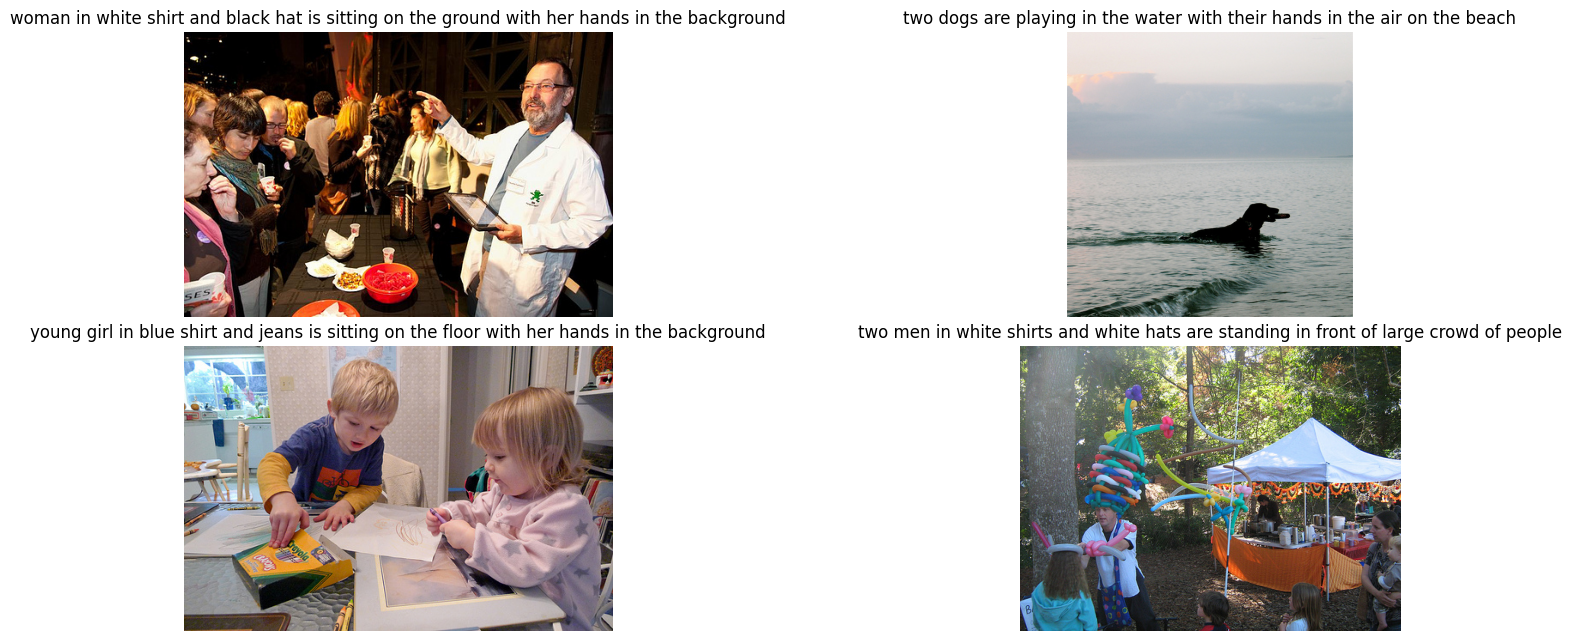

In [68]:
n=0
plt.figure(figsize = (20 , 20))
print('i  BLEU Score                   METEOR Score')
for i in range(4):
  k = random.randint(0, len(dataset))
  start = k - (k%5)
  end = k + (5 - k%5)
  #print('k =',k,',k % 5 =',k%5,'start =', start, 'end =', end)
  normal_image_path = os.path.join(dataset.data_dir, dataset.image_paths[k])
  normal_image = cv2.imread(normal_image_path)
  normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)
  image = dataset[k][0].unsqueeze(0)
  image = image.to(device, dtype=torch.float)
  full_caption, weightlist, encodinglist = inference_function2(image)
  plt.subplot(5 , 2, i+1)
  plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
  plt.axis('off')
  plt.title(' '.join(full_caption))
  plt.imshow(normal_image,aspect='equal')
  listsplit = list()
  for x in range(start,end):
    listsplit.append(dataset.captions[x].split(' '))
    #print(listsplit)
  print('{}  {:<12.14f}             {:<12.14f}'.format(i,sentence_bleu(listsplit,full_caption),meteor_score(listsplit,full_caption)))

In [69]:
wl = np.squeeze(np.array(weightlist))
wl.shape

TypeError: ignored

black dog is running through the grass


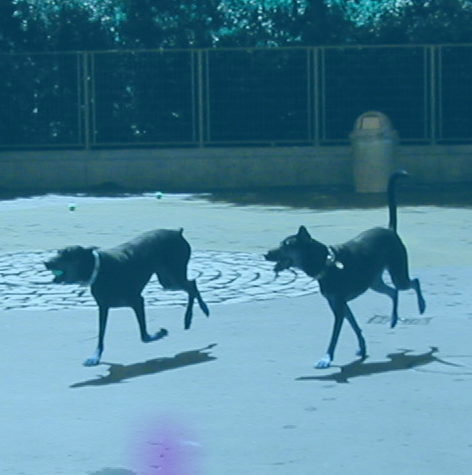

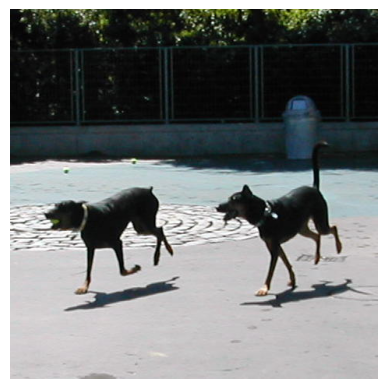

In [ ]:
import torch
from google.colab.patches import cv2_imshow
import torch.nn.functional as F
# Resize attention weights to match image dimensions
k = random.randint(0, len(dataset))
normal_image_path = os.path.join(dataset.data_dir, dataset.image_paths[k])
normal_image = cv2.imread(normal_image_path)
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)
image = dataset[k][0].unsqueeze(0)
image = image.to(device, dtype=torch.float)
full_caption, attnweights, attnencoding = inference_function(image)
plt.figure()
plt.axis('off')
plt.imshow(normal_image,aspect='equal')
attention_weights = np.squeeze(np.array(attnweights))  # Assuming attention_weights has shape (H', W')
attention_weights_tensor = torch.from_numpy(attention_weights)

resized_attention_weights = F.interpolate(torch.unsqueeze(torch.unsqueeze(attention_weights_tensor, 0), 0),
                                          size=(10, 10),
                                          mode='bilinear',
                                          align_corners=False)
resized_attention_weights = resized_attention_weights.squeeze().squeeze().detach().cpu().numpy()
normalized_attention_weights = (resized_attention_weights - resized_attention_weights.min()) / (
    resized_attention_weights.max() - resized_attention_weights.min()
)

# Load the image
image = normal_image
heatmap = cv2.applyColorMap(np.uint8(255 * normalized_attention_weights), cv2.COLORMAP_JET)
# Resize the heatmap to match the image dimensions
resized_heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# Normalize the resized heatmap between 0 and 1
normalized_heatmap = cv2.normalize(resized_heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Convert the heatmap to a color map
colormap = cv2.applyColorMap(normalized_heatmap, cv2.COLORMAP_JET)

# Blend the heatmap with the original image
attention_map = cv2.addWeighted(image, 0.7, colormap, 0.3, 0)

# Display the attention map
print(' '.join(full_caption))
cv2_imshow(attention_map)

man


<ipython-input-222-78983642b885>:17: RuntimeWarning: invalid value encountered in true_divide
  normalized_attention_weights = (resized_attention_weights - resized_attention_weights.min()) / (


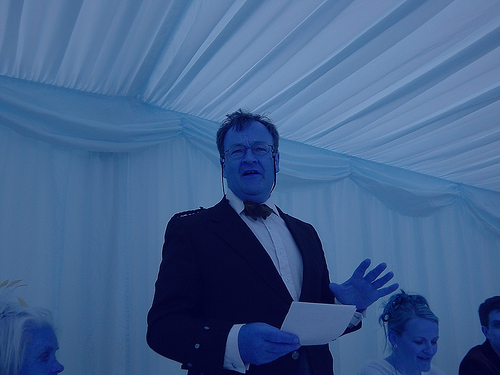

in


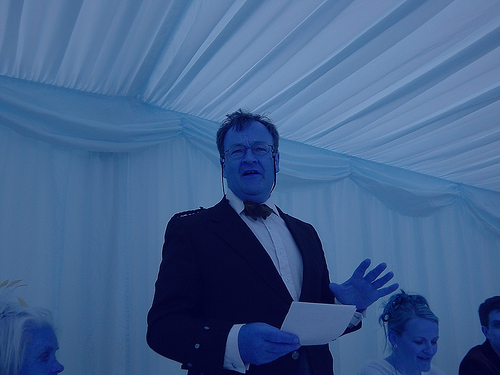

tuxedo


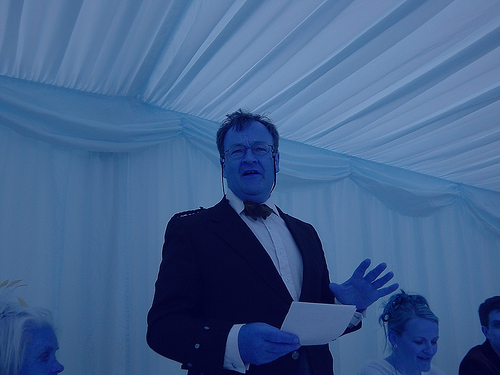

and


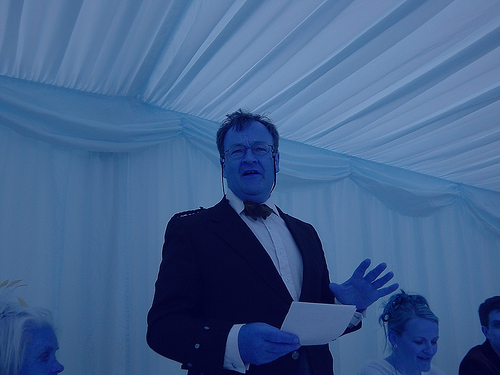

woman


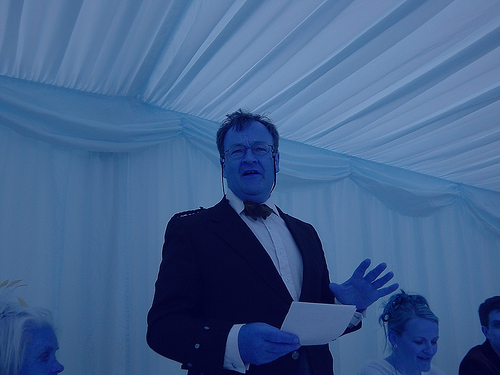

in


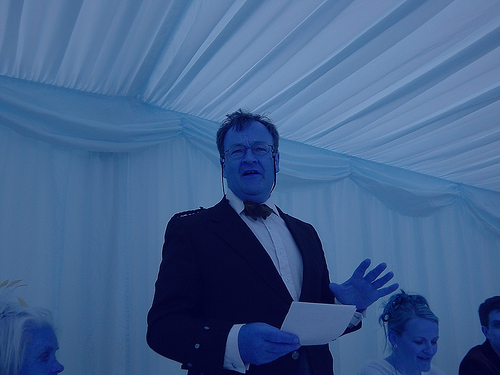

black


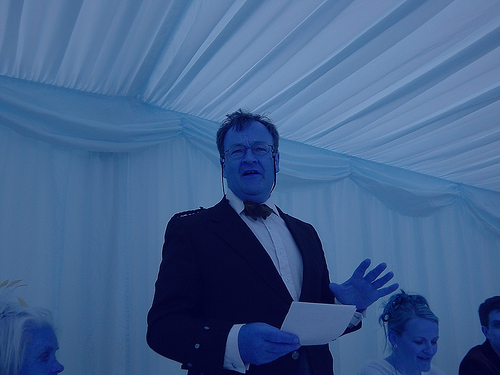

dress


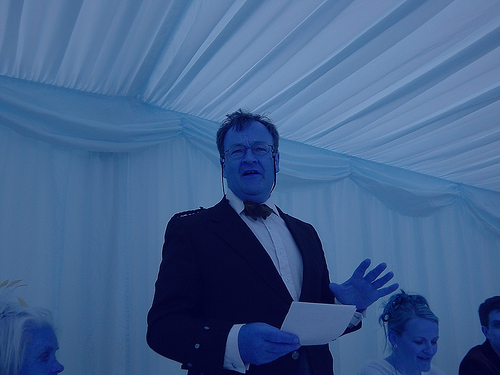

are


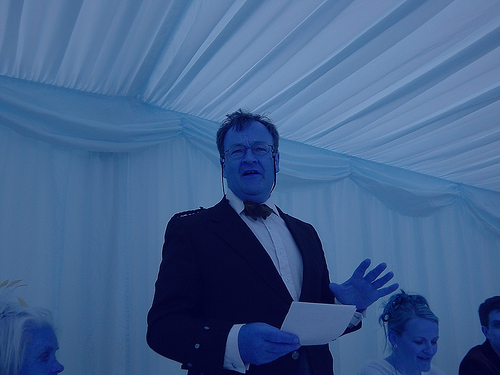

standing


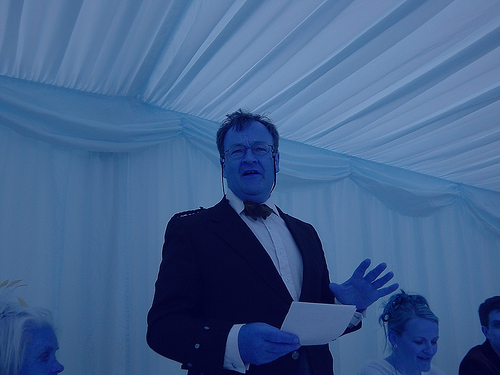

in


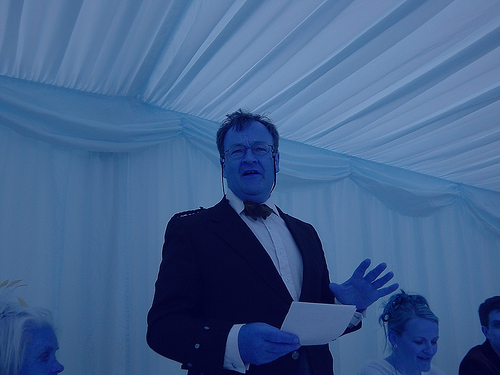

room


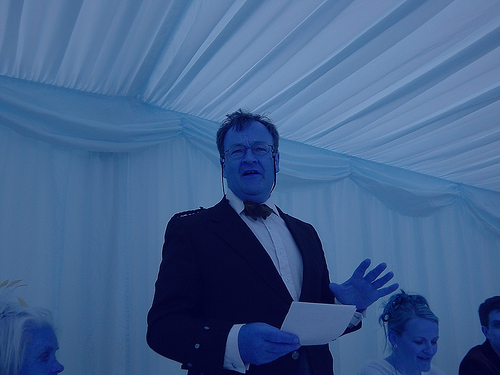

In [ ]:
import cv2

# Load the image
image = normal_image

# Assuming you have a list of predicted words from the decoder
predicted_words = full_caption

# Iterate over the predicted words and their corresponding attention weights

for word_index, word in enumerate(predicted_words):
    attention_weights = wl[word_index]  # Assuming attention_weights has shape (H', W')
    
    # Resize the attention weights to match the image dimensions
    resized_attention_weights = cv2.resize(attention_weights, (image.shape[1], image.shape[0]))
    # Normalize the resized attention weights between 0 and 1
    normalized_attention_weights = (resized_attention_weights - resized_attention_weights.min()) / (
        resized_attention_weights.max() - resized_attention_weights.min()
    )
    #print(normalized_attention_weights)
    arr8 = 255 * normalized_attention_weights
    arr8 = arr8.astype(np.uint8)
    print(word)
    # Convert the attention weights to a heatmap
    heatmap = cv2.applyColorMap(arr8, cv2.COLORMAP_JET)

    # Blend the heatmap with the original image
    attention_map = cv2.addWeighted(image, 0.7, heatmap, 0.3, 0)

    # Display the attention map with the word as the title
    cv2_imshow(attention_map)

In [ ]:
#from google.colab import files
#torch.save(encoder.state_dict(), 'encoder.pth')

# download checkpoint file
#files.download('encoder.pth')

In [ ]:
#torch.save(decoder.state_dict(), 'decoder.pth')

# download checkpoint file
#files.download('decoder.pth')

In [ ]:
def mixup(x, y, a):
    lam = np.random.beta(a,a)
    rand = torch.randperm(batch_size)
    x2 = x[rand,:]
    y2 = y[rand,:]
    X = lam * x + (1 - lam) * x2
    Y = lam * y + (1 - lam) * y2
    #print(Y)
    return X, Y

def cutout(image, k):
    x = np.random.randint(0, 128-k)
    y = np.random.randint(0, 128-k)
    image[:, x:x+k, y:y+k] = 0
    return image

def standard_augmentation(image,k):
    k1 = np.random.randint(-k, k)
    k2 = np.random.randint(-k, k)
    image = np.roll(image, k1, axis=1)
    image = np.roll(image, k2, axis=2)
    if (k1 > 0):    
        image[:, :k1, :] = 0
    else:
        image[:, k1:, :] = 0
    if (k2 > 0):
        image[:, :, :k2] = 0
    else:
        image[:, :, k2:] = 0
    if (np.random.rand() < 0.5):
        image = np.flip(image, axis=2)
    return image